#### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tqdm import tqdm 

import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier

from statsmodels.tsa.arima.model import ARIMA

#### Perform EDA and detect anomaly - BAMBOO MISSION

In [2]:
file_path = 'train.csv'
df = pd.read_csv(file_path)
print(df.describe())

         temperature          light    airHumidity       humidity
count  174360.000000  174360.000000  174360.000000  174360.000000
mean       21.610169      48.706657      69.459323      86.116717
std         3.427727      43.521437       4.954732       3.002257
min        10.857436       0.000000      49.691711      76.718130
25%        19.200176       0.000000      65.929197      84.139452
50%        21.580725      71.452690      69.974900      86.200328
75%        23.990309      90.388123      73.527058      87.881785
max        34.788918     100.000000     100.000000     100.000000


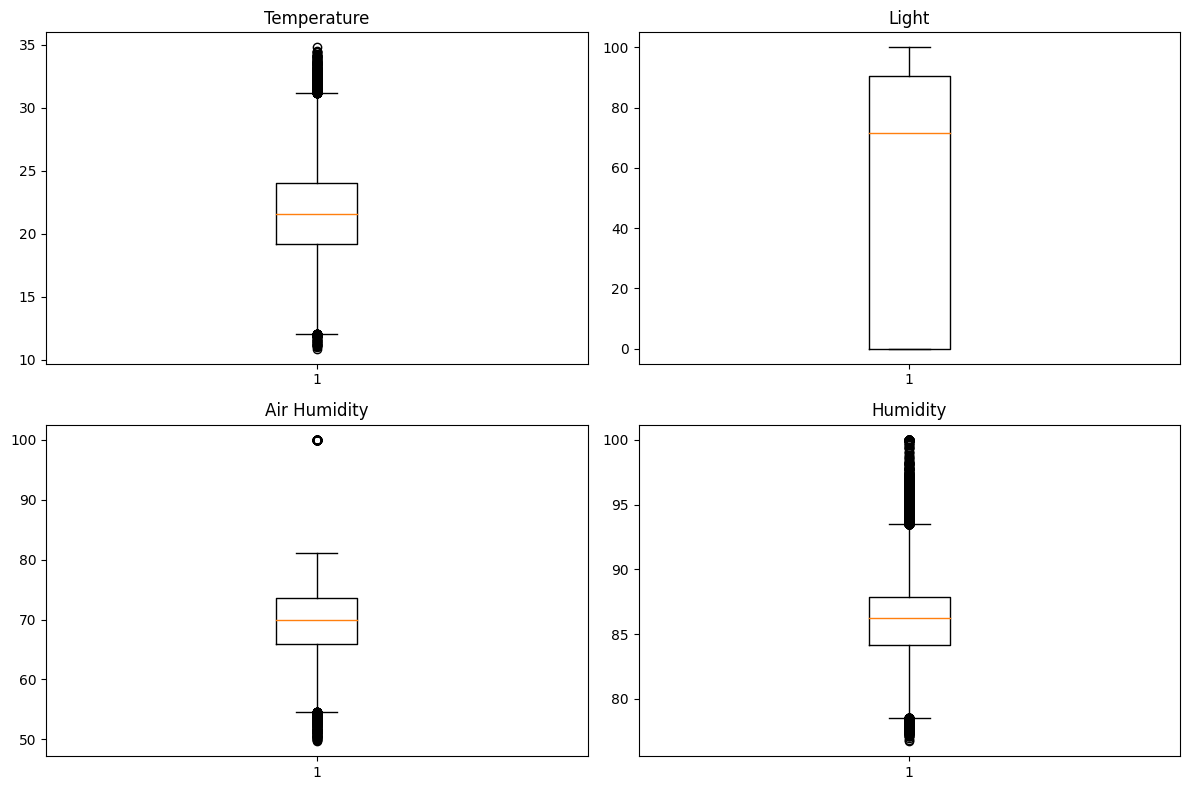

Temperature Outliers: [11.88581182 11.79158388 11.80453522 11.90533857 11.86190718 11.51208498
 11.77056295 11.59238645 11.46373106 11.34224749 11.47281406 11.14001106
 11.06806038 11.0819895  11.16130817 10.8574365  11.01421035 11.14879446
 11.2624945  11.12444064 11.36124449 11.31085409 11.32899644 11.65182644
 11.49784582 11.51470436 11.83879506 11.92935185 11.82981642 11.95716159
 11.98614009 11.87074866 11.98236251 12.01373206 11.94044588 11.91956962
 11.89908626 11.93773792 11.87508188 12.01046567 11.85405051 11.87519828
 11.93269152 11.89558183 11.93830294 11.96087611 11.98323072 11.92004756
 12.0063614  11.92691176 12.00059733 11.98121601 11.92824745 12.00569404
 11.92653027 11.99094021 11.93843183 11.93857778 11.90494769 11.92531359
 11.99551848 11.98873283 11.94313212 11.93248953 12.00884691 11.95416224
 11.98762001 11.94240652 11.93454664 11.99590538 11.98170452 11.96306689
 11.99123438 12.00773232 31.19988826 31.28214447 31.47887323 31.18785894
 31.52415985 31.31580202 31.3

In [3]:
# Visualize the data to identify outliers or errors
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
temperature_outliers = axs[0, 0].boxplot(df['temperature']).get('fliers')[0].get_data()[1]
axs[0, 0].set_title('Temperature')

light_outliers = axs[0, 1].boxplot(df['light']).get('fliers')[0].get_data()[1]
axs[0, 1].set_title('Light')

air_humidity_outliers = axs[1, 0].boxplot(df['airHumidity']).get('fliers')[0].get_data()[1]
axs[1, 0].set_title('Air Humidity')

humidity_outliers = axs[1, 1].boxplot(df['humidity']).get('fliers')[0].get_data()[1]
axs[1, 1].set_title('Humidity')

plt.tight_layout()
plt.show()

# Print the outliers
print("Temperature Outliers:", temperature_outliers)
print("Light Outliers:", light_outliers)
print("Air Humidity Outliers:", air_humidity_outliers)
print("Humidity Outliers:", humidity_outliers)

In [4]:
df['temperature'] = df['temperature'].apply(lambda x: x if 20 <= x <= 30 else None)
df['airHumidity'] = df['airHumidity'].apply(lambda x: x if 60 <= x <= 80 else None)

# # Save corrected data to a new CSV file
# corrected_file_path = 'anomaly.csv'
# df.to_csv(corrected_file_path, index=False)

In [5]:
file_path = 'anomaly.csv'
df = pd.read_csv(file_path)
print(df.describe())

         temperature          light    airHumidity       humidity
count  114764.000000  174360.000000  167444.000000  174360.000000
mean       23.368779      48.706657      69.880719      86.116717
std         2.215114      43.521437       4.418975       3.002257
min        20.000045       0.000000      60.000028      76.718130
25%        21.554444       0.000000      66.365567      84.139452
50%        23.155719      71.452690      70.260089      86.200328
75%        24.740388      90.388123      73.617622      87.881785
max        29.999947     100.000000      79.996075     100.000000


In [6]:
df.head()

,ts,temperature,light,airHumidity,humidity
0,10/07/2023 00:00,24.558222,0.0,72.278208,86.485813
1,10/07/2023 00:01,24.849800,0.0,72.191887,85.327090
2,10/07/2023 00:02,24.788302,0.0,70.960825,85.372834
3,10/07/2023 00:03,24.979886,0.0,71.424718,85.828448
4,10/07/2023 00:04,24.462985,0.0,71.010175,86.997323


In [7]:
columns_to_average = ['temperature', 'airHumidity']
df[columns_to_average] = df[columns_to_average].apply(pd.to_numeric, errors='coerce')
mean_values = df[columns_to_average].mean()
df[columns_to_average] = df[columns_to_average].fillna(mean_values)

print(df.describe())

         temperature          light    airHumidity       humidity
count  174360.000000  174360.000000  174360.000000  174360.000000
mean       23.368779      48.706657      69.880719      86.116717
std         1.797111      43.521437       4.330449       3.002257
min        20.000045       0.000000      60.000028      76.718130
25%        22.377062       0.000000      66.521188      84.139452
50%        23.368779      71.452690      69.946559      86.200328
75%        23.899319      90.388123      73.504236      87.881785
max        29.999947     100.000000      79.996075     100.000000


#### Let make forecast - BROCCOLI MISSION

In [10]:
# import numpy as np
# import pandas as pd
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# from tqdm import tqdm

# def prepare_data(data):
#     """
#     Preprocess the data, convert the date column to datetime, and set it as the index.
#     """
#     data['ts'] = pd.to_datetime(data['ts'], format="%d/%m/%Y %H:%M")
#     data.set_index('ts', inplace=True)
#     return data

# def train_model_and_predict_future(model, train_data, test_size=0.2, steps_ahead=14 * 24 * 60):
#     """
#     Train the model on the training dataset, evaluate on a portion of the training dataset,
#     and predict future values for all columns.
#     """
#     split_index = int(len(train_data) * (1 - test_size))
#     train_split, eval_split = train_data.iloc[:split_index], train_data.iloc[split_index:]

#     X_train = train_split.drop(columns=train_data.columns)  # Use all columns as features
#     y_train = train_split

#     X_eval = eval_split.drop(columns=train_data.columns)
#     y_eval = eval_split

#     model.fit(X_train.values, y_train.values)

#     # Evaluate on the evaluation set
#     eval_predictions = model.predict(X_eval.values)
#     mse_eval = mean_squared_error(y_eval.values, eval_predictions)
#     mae_eval = mean_absolute_error(y_eval.values, eval_predictions)
#     print(f"Evaluation - MSE: {mse_eval}, MAE: {mae_eval}")

#     # Predict future values
#     future_dates = pd.date_range(start=train_data.index[-1], periods=steps_ahead + 1, freq='T')[1:]
#     future_X = pd.DataFrame(index=future_dates, columns=train_data.columns)
#     future_X.fillna(0, inplace=True)  # Fill with appropriate default values or preprocess as needed

#     future_predictions = []

#     # Use tqdm to create a progress bar
#     for _ in tqdm(range(steps_ahead)):
#         prediction_step = model.predict(future_X.iloc[[_]].values)
#         future_predictions.append(prediction_step[0])

#     return eval_predictions, mse_eval, mae_eval, future_dates, future_predictions
#  # Replace with your actual data file
# data = prepare_data(df)

# # Example for Random Forest Regression
# model_rf = RandomForestRegressor()
# eval_predictions_rf, mse_eval_rf, mae_eval_rf, future_dates_rf, future_predictions_rf = train_model_and_predict_future(model_rf, data)
# print(f"Random Forest - Evaluation MSE: {mse_eval_rf}, MAE: {mae_eval_rf}")
# print(f"Random Forest - Future Predictions: {future_predictions_rf}")

# # Print the number of predictions
# print(f"Number of predictions: {len(future_dates_rf)}")


C:\Users\sulei\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
C:\Users\sulei\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
C:\Users\sulei\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)


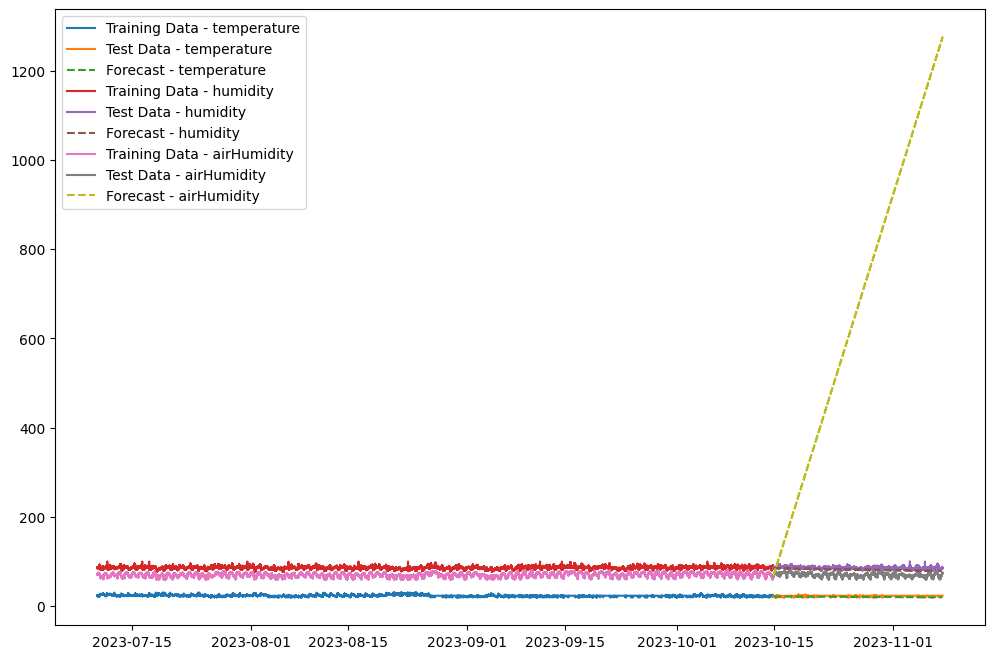

In [38]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Train-test split (adjust as needed)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Columns to forecast
columns_to_forecast = ['temperature', 'humidity', 'airHumidity']

# Dictionary to store forecast results
forecast_results = {}

# Loop through columns and perform forecasting
for column in columns_to_forecast:
    # Model initialization and training
    model = ExponentialSmoothing(train[column], trend='add', seasonal='add', seasonal_periods=12)
    fit_model = model.fit()

    # Forecasting
    forecast = fit_model.forecast(len(test))

    # Store the forecast results
    forecast_results[column] = forecast

# Plotting the results
plt.figure(figsize=(12, 8))

for column in columns_to_forecast:
    plt.plot(train.index, train[column], label=f'Training Data - {column}')
    plt.plot(test.index, test[column], label=f'Test Data - {column}')
    plt.plot(test.index, forecast_results[column], label=f'Forecast - {column}', linestyle='dashed')

plt.legend()
plt.show()


#### Let get conditions to generate labels and train a classifier 

In [8]:
file_path = 'anomaly.csv'
df = pd.read_csv(file_path)
columns_to_average = ['temperature', 'airHumidity']
df[columns_to_average] = df[columns_to_average].apply(pd.to_numeric, errors='coerce')
mean_values = df[columns_to_average].mean()
df[columns_to_average] = df[columns_to_average].fillna(mean_values)
df

,ts,temperature,light,airHumidity,humidity
0,10/07/2023 00:00,24.558222,0.0,72.278208,86.485813
1,10/07/2023 00:01,24.849800,0.0,72.191887,85.327090
2,10/07/2023 00:02,24.788302,0.0,70.960825,85.372834
3,10/07/2023 00:03,24.979886,0.0,71.424718,85.828448
4,10/07/2023 00:04,24.462985,0.0,71.010175,86.997323
...,...,...,...,...,...
174355,08/11/2023 01:55,23.368779,0.0,73.498898,85.142143
174356,08/11/2023 01:56,23.368779,0.0,73.951127,86.208380
174357,08/11/2023 01:57,23.368779,0.0,72.988022,86.148726
174358,08/11/2023 01:58,23.368779,0.0,74.672621,84.899199


In [9]:
df['label'] = 0

# Update the 'label' column based on your conditions
condition = (
    (df['temperature'].between(20, 25)) &
    (df['airHumidity'].between(65, 75)) &
    (df['humidity'].between(83, 93))
)

df.loc[condition, 'label'] = 1
df

,ts,temperature,light,airHumidity,humidity,label
0,10/07/2023 00:00,24.558222,0.0,72.278208,86.485813,1
1,10/07/2023 00:01,24.849800,0.0,72.191887,85.327090,1
2,10/07/2023 00:02,24.788302,0.0,70.960825,85.372834,1
3,10/07/2023 00:03,24.979886,0.0,71.424718,85.828448,1
4,10/07/2023 00:04,24.462985,0.0,71.010175,86.997323,1
...,...,...,...,...,...,...
174355,08/11/2023 01:55,23.368779,0.0,73.498898,85.142143,1
174356,08/11/2023 01:56,23.368779,0.0,73.951127,86.208380,1
174357,08/11/2023 01:57,23.368779,0.0,72.988022,86.148726,1
174358,08/11/2023 01:58,23.368779,0.0,74.672621,84.899199,1


In [10]:
label_counts = df['label'].value_counts()
print(label_counts)

label
1    97953
0    76407
Name: count, dtype: int64


#### Machine Learning models - AVOCADO MISSION

In [11]:
df = df.drop(columns=['ts'])
X = df.drop(columns=['label'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Define a list of classifiers
classifiers = {
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(),
    'Logistic Regression': LogisticRegression(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42)
}

# Iterate through each classifier
for name, model in classifiers.items():
    print(f"Training and evaluating {name}...")
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = []
    for train_idx, val_idx in tqdm(cv.split(X_train_scaled, y_train), total=cv.get_n_splits(), desc=f"{name} Cross-Validation"):
        X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)
        y_val_pred = model.predict(X_val_fold)
        cv_scores.append(accuracy_score(y_val_fold, y_val_pred))
    
    # Print cross-validation scores
    print(f"{name} Cross-Validation Scores:", cv_scores)
    print(f"{name} Mean Accuracy:", sum(cv_scores) / len(cv_scores))
    
    # Train the model on the entire training set
    model.fit(X_train_scaled, y_train)
    
    # Make predictions on the test set
    X_test_scaled = scaler.transform(X_test)
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate the model on the test set
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Test Accuracy:", accuracy)
    print()


Training and evaluating SVM...


SVM Cross-Validation: 100%|██████████| 10/10 [08:22<00:00, 50.22s/it]


SVM Cross-Validation Scores: [0.9840848806366048, 0.9840131909097426, 0.9844433292709155, 0.9837981217291563, 0.9855903649007097, 0.9855186751738476, 0.9817908093770162, 0.984228260090329, 0.9842271293375394, 0.9853742472039002]
SVM Mean Accuracy: 0.984306900862976
SVM Test Accuracy: 0.9849736178022482

Training and evaluating Random Forest...


Random Forest Cross-Validation: 100%|██████████| 10/10 [03:37<00:00, 21.75s/it]


Random Forest Cross-Validation Scores: [1.0, 1.0, 0.9999283102731379, 0.9999283102731379, 1.0, 1.0, 1.0, 1.0, 0.9999283051333524, 1.0]
Random Forest Mean Accuracy: 0.9999784925679629
Random Forest Test Accuracy: 0.9999426473961918

Training and evaluating KNN...


KNN Cross-Validation: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


KNN Cross-Validation Scores: [0.9886013334289196, 0.9866657108036418, 0.9865940210767797, 0.987239228618539, 0.9883862642483332, 0.9864506416230554, 0.9864506416230554, 0.9860205032618826, 0.9878118726699169, 0.9859478061370806]
KNN Mean Accuracy: 0.9870168023491205
KNN Test Accuracy: 0.9885581555402615

Training and evaluating XGBoost...


XGBoost Cross-Validation: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


XGBoost Cross-Validation Scores: [0.9959853752957202, 0.9946949602122016, 0.9956269266614094, 0.9955552369345473, 0.9954835472076852, 0.9957703061151337, 0.995411857480823, 0.995913685568858, 0.9959850874677373, 0.9961284772010324]
XGBoost Mean Accuracy: 0.9956555460145149
XGBoost Test Accuracy: 0.9953257627896307

Training and evaluating Logistic Regression...


Logistic Regression Cross-Validation: 100%|██████████| 10/10 [00:00<00:00, 16.00it/s]


Logistic Regression Cross-Validation Scores: [0.7242096207613449, 0.7171840275288551, 0.7162520610796473, 0.7163954405333716, 0.7180443042512008, 0.7103735034769517, 0.7145315076349559, 0.7179009247974765, 0.7153713794092343, 0.7131488385431604]
Logistic Regression Mean Accuracy: 0.7163411608016197
Logistic Regression Test Accuracy: 0.7133230098646478

Training and evaluating AdaBoost...


AdaBoost Cross-Validation: 100%|██████████| 10/10 [01:23<00:00,  8.37s/it]


AdaBoost Cross-Validation Scores: [1.0, 1.0, 0.9999283102731379, 1.0, 1.0, 0.9999283102731379, 1.0, 1.0, 0.9999283051333524, 1.0]
AdaBoost Mean Accuracy: 0.9999784925679627
AdaBoost Test Accuracy: 0.9999713236980959



#### Build an ensemble

In [12]:
# Define the top five models based on their test accuracy
top_models = {
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(),
    'AdaBoost': AdaBoostClassifier(random_state=42)
}

best_five_models = {name: model for name, model in top_models.items()}
ensemble_model = VotingClassifier(estimators=list(best_five_models.items()), voting='hard')

ensemble_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_ensemble_pred = ensemble_model.predict(X_test_scaled)

# Evaluate the ensemble model on the test set
ensemble_accuracy = accuracy_score(y_test, y_ensemble_pred)
print("Ensemble Test Accuracy:", ensemble_accuracy)

Ensemble Test Accuracy: 0.998938976829548


In [13]:
top_models = {
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(),
    'AdaBoost': AdaBoostClassifier(random_state=42)
}

# Ensemble
best_five_models = {name: model for name, model in top_models.items()}
ensemble_model = VotingClassifier(estimators=list(best_five_models.items()), voting='soft')
ensemble_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_ensemble_pred = ensemble_model.predict(X_test_scaled)

# Evaluate the ensemble model on the test set
ensemble_accuracy = accuracy_score(y_test, y_ensemble_pred)
print("Ensemble Test Accuracy:", ensemble_accuracy)

Ensemble Test Accuracy: 0.9998279421885754
